In [279]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import Tuple
import warnings

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import r_regression
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

# 1. EDA and data cleaning
The datasets are provided without column names, so these have been gathered from `census_income_metadata.txt`.

In [280]:
columns = [
    "age",
    "class of worker",
    "industry code",
    "occupation code",
    "education",
    "wage per hour",
    "enrolled in edu inst last wk",
    "marital status",
    "major industry code",
    "major occupation code",
    "race",
    "hispanic Origin",
    "sex",
    "member of a labor union",
    "reason for unemployment",
    "full or part time employment stat",
    "capital gains",
    "capital losses",
    "dividends from stocks",
    "tax filer status",
    "region of previous residence",
    "state of previous residence",
    "detailed household and family stat",
    "detailed household summary in household",
    "instance weight",
    "migration code-change in msa",
    "migration code-change in reg",
    "migration code-move within reg",
    "live in this house 1 year ago",
    "migration prev res in sunbelt",
    "num persons worked for employer",
    "family members under 18",
    "country of birth father",
    "country of birth mother",
    "country of birth self",
    "citizenship",
    "own business or self employed",
    "fill inc questionnaire for veteran's admin",
    "veterans benefits",
    "weeks worked in year",
    "year of census",
    "50K",
]


In [281]:
train = pd.read_csv(
    "data/census_income_learn.csv", names=columns, header=None, na_values=" Not in universe"
)
test = pd.read_csv(
    "data/census_income_test.csv", names=columns, header=None, na_values=" Not in universe"
)

The metadata mentions that `instance weight` should not be used in classifiers, so it is removed.

In [282]:
train = train.drop("instance weight", axis=1)
test = test.drop("instance weight", axis=1)

We change the type of the columns that have numerical values but should be numerical.

In [283]:
categorical_col = [
    "own business or self employed",
    "industry code",
    "occupation code",
    "year of census",
    "veterans benefits",
]
train.loc[:, categorical_col] = train[categorical_col].astype("object")
test.loc[:, categorical_col] = test[categorical_col].astype("object")


In [284]:
le = LabelEncoder()
train['50K'] = le.fit_transform(train['50K'])
test['50K'] = le.transform(test['50K'])

In [285]:
X_train_raw, y_train = train.drop("50K", axis=1), train["50K"]
X_test_raw, y_test = test.drop("50K", axis=1), test["50K"]
y_train.value_counts(normalize=True)

0    0.937942
1    0.062058
Name: 50K, dtype: float64

We notice a very strong dataset imbalance, with only 6% revenues over 50K. 
We could resample classes to compensate for this imbalance, however if we resample to have 50% of each class and train our models on this resampled datasets, the predictions will be done under the assumption of balanced data, which will !ost probably be false on the test set: so we prefer not to resample.

### Missing values: display proportions

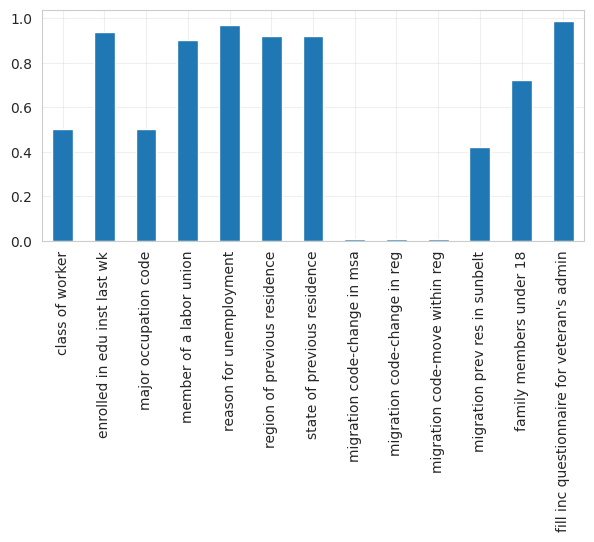

In [286]:
X_train_null = X_train_raw.isna().sum() / len(X_train_raw)
plt.figure(figsize=(7, 3))
X_train_null[X_train_null > 0].T.plot(kind="bar")
plt.grid(alpha=0.3)

On the above graph, we see that:
- no numeric feature has null columns
- categorical features have missing values:
    - never 100%, so there's no need to drop any feature
    - missing values will be handled as an independant category in one-hot encoding.


So there's no need to input missing columns in the training set, but we will still include missing value filling in the data cleaning pipeline since values could be missing in the test.

### Explore data distribution

In [287]:
num_cols = X_train_raw.select_dtypes(include=[int]).columns
cat_cols = X_train_raw.select_dtypes(include=["object"]).columns
for feature in (pbar := tqdm(cat_cols[:10])):
    pbar.set_description(feature)
    plt.figure(figsize=(X_train_raw[feature].nunique(), 5))
    sns.histplot(data = train, x = feature, hue = '50K', multiple="stack", edgecolor=None)
    plt.xticks(rotation = 80)
    plt.tight_layout()
    plt.savefig(f"views/{feature}.png")
    plt.close()

hispanic Origin: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]            


weeks worked in year: : 7it [00:01,  6.65it/s]           


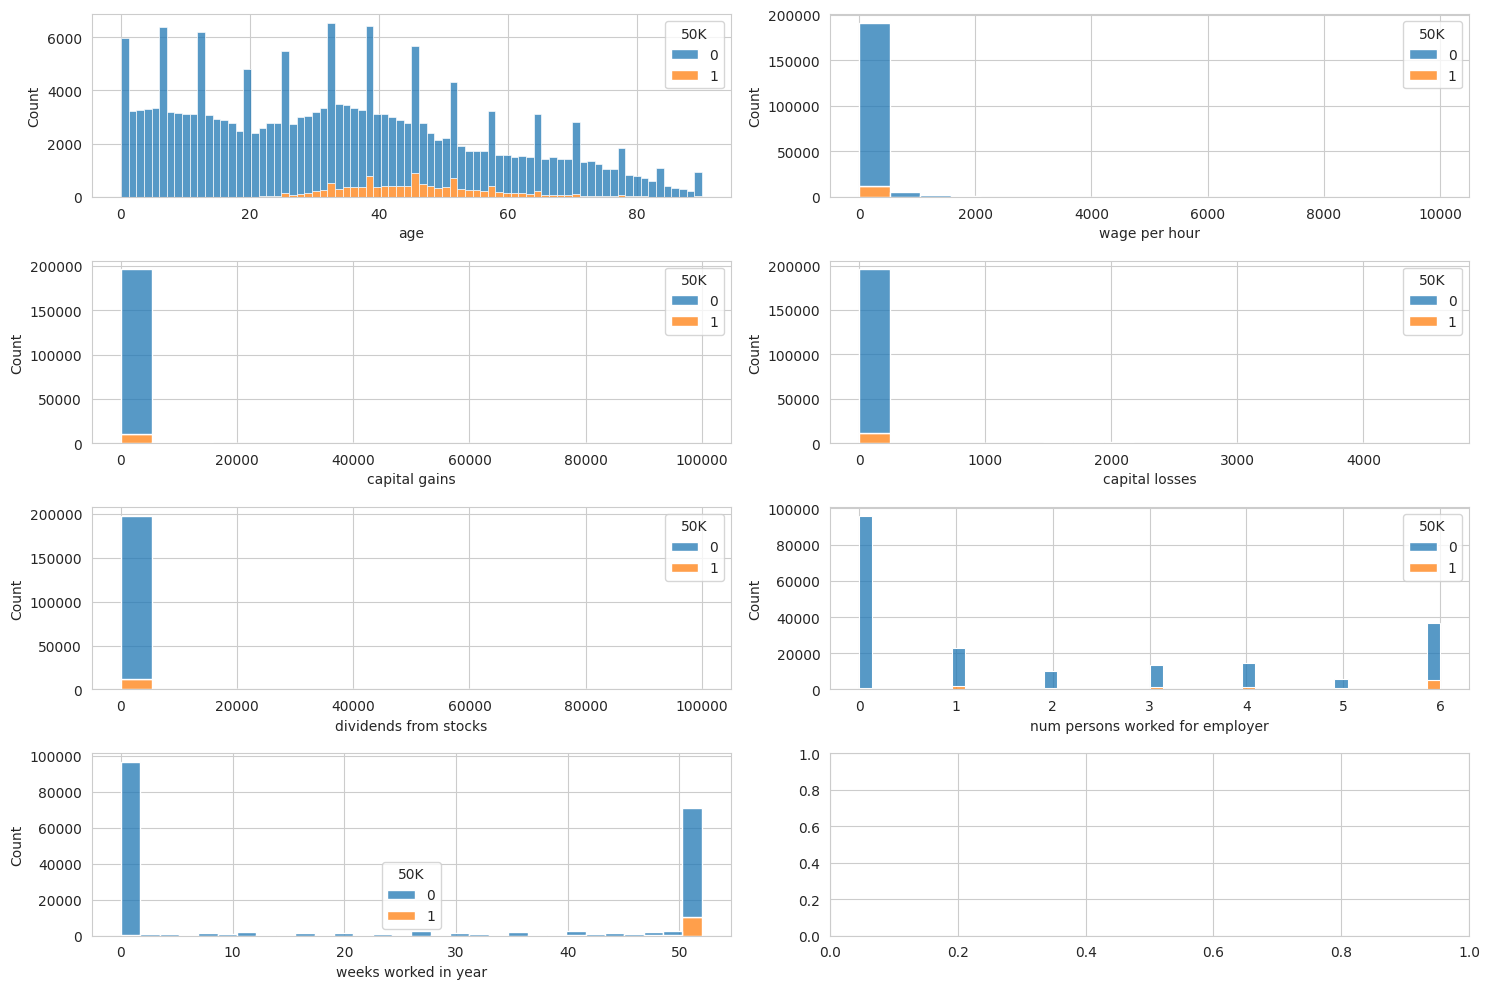

In [288]:
fig, axes = plt.subplots(math.ceil(len(num_cols) / 2), 2, figsize=(15,10))
for ax, feature in (pbar:=tqdm(zip(axes.ravel(), num_cols))):
    pbar.set_description(feature)
    sns.histplot(data = train, x = feature, hue = '50K', ax= ax, multiple="stack", edgecolor=None)
plt.tight_layout()
plt.savefig(f"views/numeric_features.png")
plt.show()

# 2. Feature engineering
For the encoding, we first want to encode all categorical as One-Hot features, because this is a good way to take into account categorical features that do not have a particular order (best alternative for a feature from which different labels have a clear ordered impact on the target is to use ordinal encoding); this has the downside of increasing dataset dimensionality.

In [289]:
class DataPreprocessor():
    def __init__(self, X_train: pd.DataFrame) -> None:
        self.num_cols = X_train.select_dtypes(include=[int]).columns
        self.cat_cols = X_train.select_dtypes(include=["object"]).columns
        
        self.num_pipeline = Pipeline(
            [
                ("imputer", SimpleImputer(missing_values=np.nan, strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
        self.num_pipeline.fit(X_train[self.num_cols])

        # OneHotEncoder treats nan values as a category per se => no need to input missing values
        self.cat_pipeline = OneHotEncoder(drop='if_binary')
        self.cat_pipeline.fit(X_train[cat_cols])

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_num_cols = pd.DataFrame(
            self.num_pipeline.transform(X[self.num_cols]),
            columns = self.num_cols
        )
        X_cat_cols = self.cat_pipeline.transform(X[self.cat_cols])
        X_cat_cols = pd.DataFrame.sparse.from_spmatrix(
            X_cat_cols,
            columns=list(self.cat_pipeline.get_feature_names_out())
        )
        return pd.concat([X_num_cols, X_cat_cols], axis=1)

preprocess = DataPreprocessor(X_train_raw)
X_train = preprocess.transform(X_train_raw)

### Feature selection
The dataset has over 500 features as such: in order to reduce the load on my computer, I will only keep the most impactful features, as ranked by Pearson coefficient.

<BarContainer object of 40 artists>

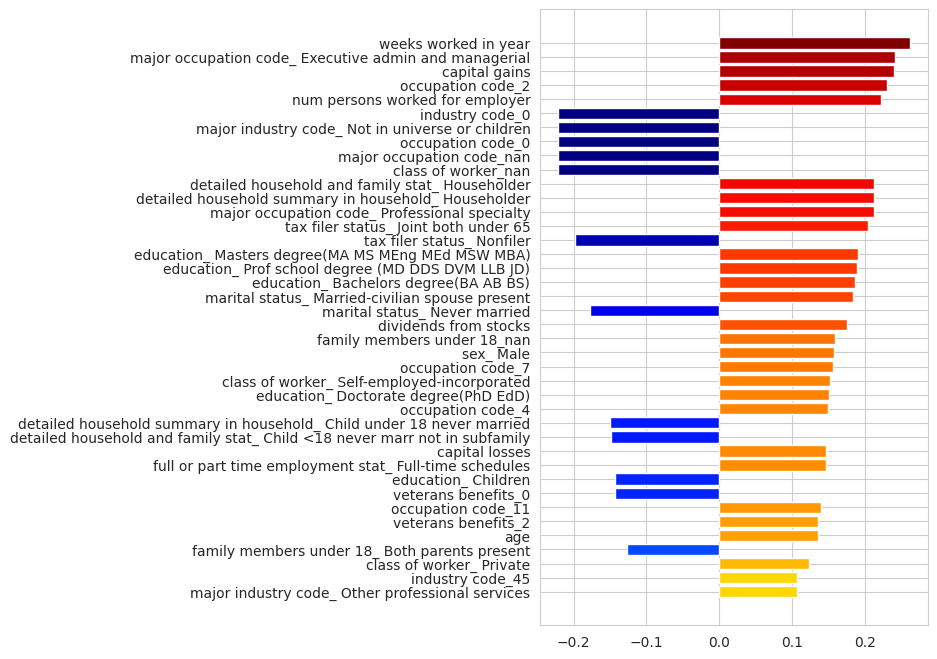

In [290]:
absolute_pearson_coefficients = pd.Series(
    np.abs(r_regression(X_train, y_train)), index=X_train.columns
)
selected_features = absolute_pearson_coefficients.sort_values().tail(40).index

pearson_coefficients = pd.Series(
    r_regression(X_train[selected_features], y_train), index=selected_features
)
cmap = plt.get_cmap("jet")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
plt.figure(figsize=(5, 8))
plt.barh(
    pearson_coefficients.index,
    width=pearson_coefficients,
    color=cmap(rescale(pearson_coefficients)),
)

We selected the features having he highest correlation with the target: this creates a high risk of selecting a highly correlated set of features. Thus we want to remove redundant features. To this end we plot the correlation matrix of our selected features.

<AxesSubplot: >

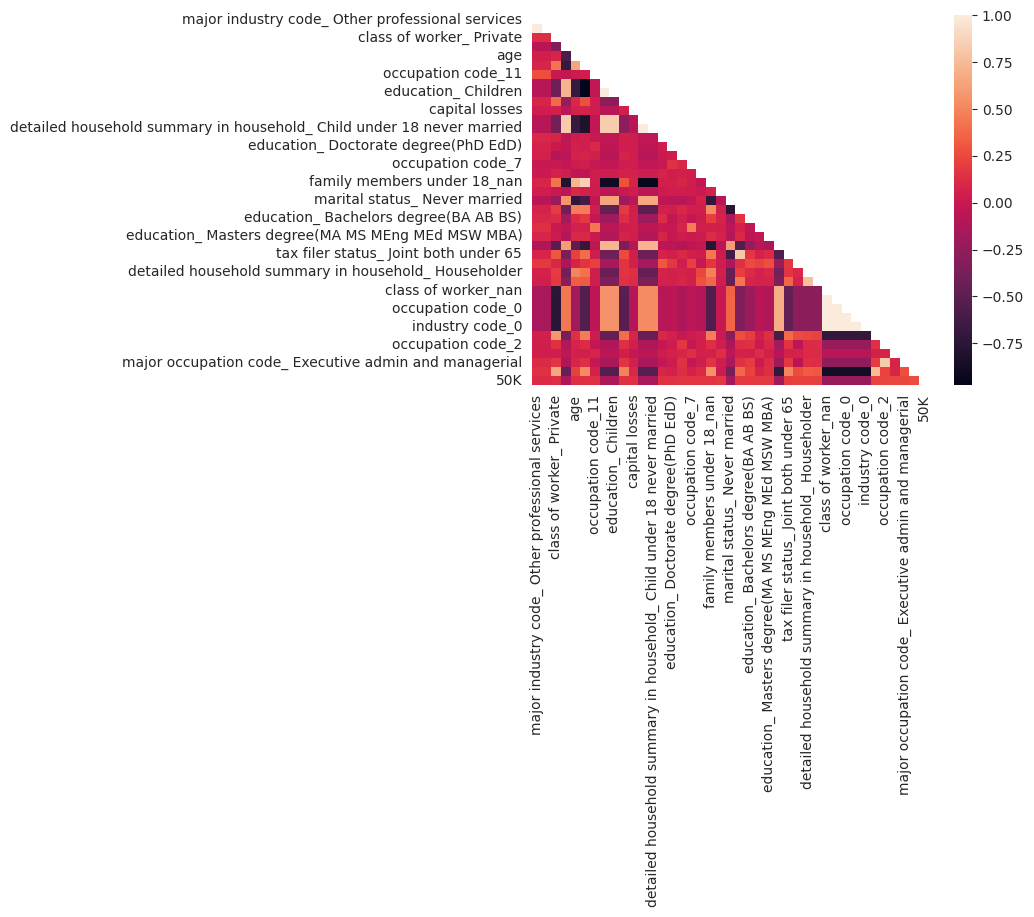

In [291]:
correlation_matrix = pd.concat(
    [X_train[selected_features], y_train], axis=1
).corr(method="pearson")
sns.heatmap(correlation_matrix, mask=np.triu(np.ones(len(correlation_matrix))))

In [292]:
removed_columns = []
for i, column_a in enumerate(correlation_matrix.columns):
    for j in range(i):
        column_b = correlation_matrix.columns[j]
        corr = correlation_matrix.loc[column_a, column_b]
        if abs(corr) > 0.7:
            removed_columns.append(column_b)

In [293]:
removed_columns

['major industry code_ Other professional services',
 'family members under 18_ Both parents present',
 'veterans benefits_2',
 'family members under 18_ Both parents present',
 'veterans benefits_2',
 'veterans benefits_0',
 'family members under 18_ Both parents present',
 'veterans benefits_2',
 'veterans benefits_0',
 'education_ Children',
 'family members under 18_ Both parents present',
 'veterans benefits_2',
 'veterans benefits_0',
 'education_ Children',
 'detailed household and family stat_ Child <18 never marr not in subfamily',
 'family members under 18_ Both parents present',
 'age',
 'veterans benefits_2',
 'veterans benefits_0',
 'education_ Children',
 'detailed household and family stat_ Child <18 never marr not in subfamily',
 'detailed household summary in household_ Child under 18 never married',
 'age',
 'family members under 18_nan',
 'marital status_ Never married',
 'veterans benefits_2',
 'veterans benefits_0',
 'education_ Children',
 'detailed household and 

Plotting the feature correlations show that some of our data is redundant: some even have have correlation of 1:
````python
[
    "class of worker_nan",
    "major occupation code_nan",
    "occupation code_0",
    "major industry code_ Not in universe or children",
    "industry code_0",
]
````
This is only logical since they all mean "not working": therefore we keep only `class of worker_nan` and remove the others.
We remove all too strongly correlated features, setting an arbitrary threshold of a pearson correlation of 0.7.

In [294]:
selected_features = [
    feature
    for feature in selected_features
    if feature
    not in removed_columns
]
X_train = X_train[selected_features]

<AxesSubplot: >

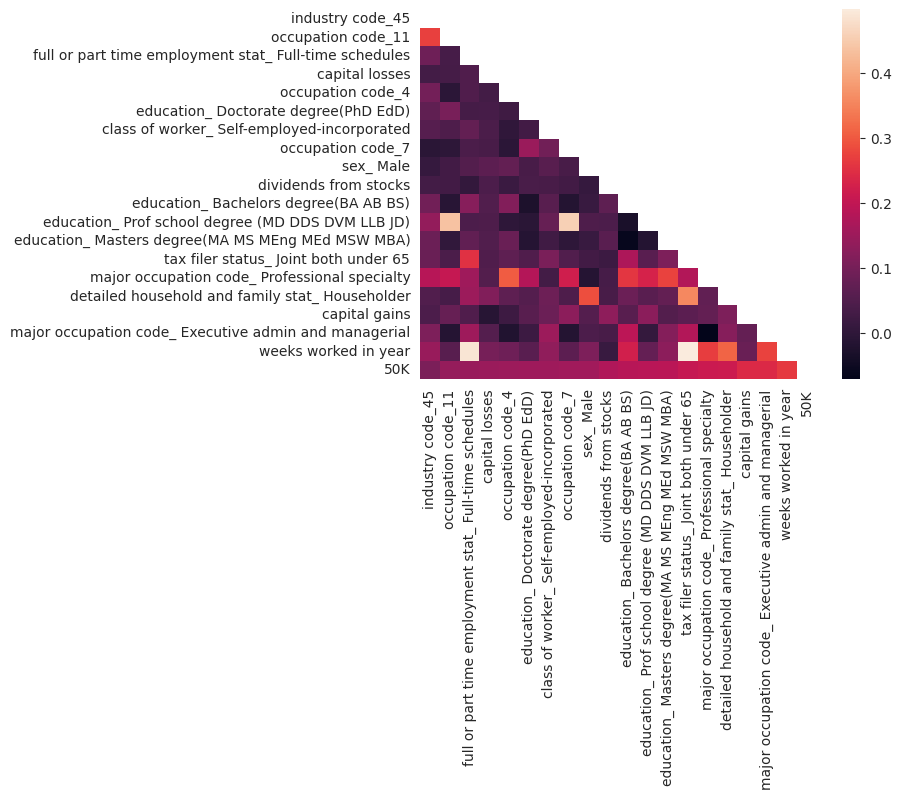

In [295]:
correlation_matrix = pd.concat(
    [X_train[selected_features], y_train], axis=1
).corr(method="pearson")
sns.heatmap(correlation_matrix, mask=np.triu(np.ones(len(correlation_matrix))))

# 3. Model tuning and selection

### Evaluation metrics
The dataset has a strong imbalance, which incites us to use a F1 score. We could also use a $F_{\beta}$ score, with $\beta$ higher than 1 depending on how much it's important to maximize true positive vs to maximize true negatives, but in the absence of any indication on this subject, we keep the F1 score, of which the formula is:

$F1 = \frac{Precision * Recall}{Precision + Recall}$

In particular, we choose not to use the AUC, since it averages sensitivity over all values of (1 - specificity), which we would not have done in this setting of a massively unbalanced dataset because the average nearly ignores the minority label.

In [296]:
def get_cross_validation_score(
    scoring: str, X: pd.DataFrame, y: pd.Series, model: BaseEstimator, **model_kwargs
) -> Tuple[float, float]:
    model = model(**model_kwargs)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=1)
    return np.mean(cv_scores), np.std(cv_scores)

### Hyperparameter tuning

Here we will perform a very basic hyperparameter (HPP) tuning example, just to display the method. We restrict ourselves to tuning only one HPP per model, but in reality there would be several hyperparameters involved, and a complete tuning process could involve Random Search on a grid of parameters, or  a Bayesian optimization based on Gaussian Processes.

In [297]:
def plot_hyperparameters(hpp_values, scores_avg, scores_std, hpp_label, log_scale_x=False):
    scores_avg = np.array(scores_avg)
    scores_std = np.array(scores_std)
    if log_scale_x:
        plt.semilogx(hpp_values, scores_avg, "x-")
    else:
        plt.plot(hpp_values, scores_avg, marker="x")
    plt.fill_between(
        hpp_values, scores_avg - 2 * scores_std, scores_avg + 2 * scores_std, alpha=0.2
    )  # "2*sigma" interval gets the 99% confidence interval
    plt.xlabel(f"Value of hyperparameter {hpp_label}")
    plt.ylabel("f1-score")
    plt.show()

#### Logistic Regression

Let us start with the simplest model, a Logistic Regression, which provides a baseline of predictive performance.

Running K-Fold with positive_class_weight = 5.5: 100%|██████████| 10/10 [01:19<00:00,  8.00s/it]


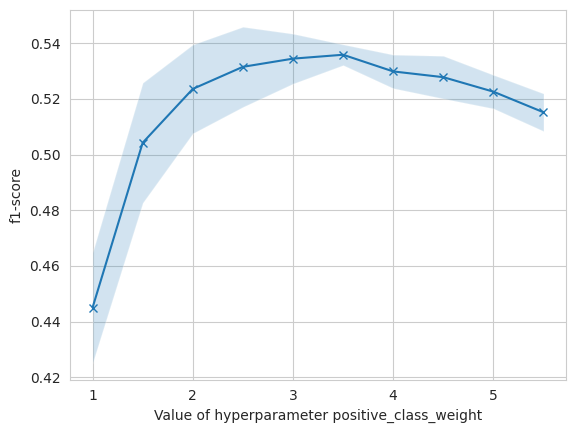

Optimal positive_class_weight for LogisticRegression = 3.5


In [299]:
scores = []
scores_std = []
list_positive_class_weight = np.arange(1, 6, 0.5)
for positive_class_weight in (pbar := tqdm(list_positive_class_weight)):
    pbar.set_description(
        f"Running K-Fold with positive_class_weight = {positive_class_weight}"
    )
    score, score_std = get_cross_validation_score(
        "f1",
        X_train,
        y_train,
        LogisticRegression,
        class_weight={0: 1, 1: positive_class_weight},
    )
    scores.append(score)
    scores_std.append(score_std)

plot_hyperparameters(
    list_positive_class_weight, scores, scores_std, "positive_class_weight"
)

optimal_positive_class_weight_lr = list_positive_class_weight[np.argmax(scores)]
print(
    f"Optimal positive_class_weight for LogisticRegression = {optimal_positive_class_weight_lr}"
)

##### Random Forest
Random forest is an ensemble model that has been shown to regularly achieve excellent performance on tabular data. It works by aggregating votes of an ensemble (forest) of Decision Trees.

Running K-Fold with positive_class_weight = 5.5: 100%|██████████| 10/10 [06:57<00:00, 41.79s/it]


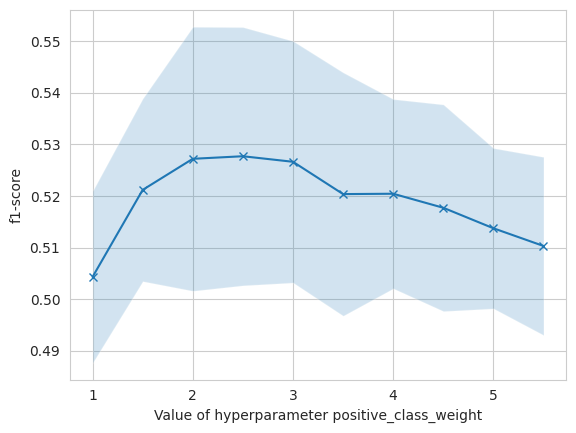

Optimal positive_class_weight for Random Forest = 2.5


In [300]:
scores = []
scores_std = []
list_positive_class_weight = np.arange(1, 6, 0.5)
for positive_class_weight in (pbar := tqdm(list_positive_class_weight)):
    pbar.set_description(
        f"Running K-Fold with positive_class_weight = {positive_class_weight}"
    )
    score, score_std = get_cross_validation_score(
        "f1",
        X_train,
        y_train,
        RandomForestClassifier,
        class_weight={0: 1, 1: positive_class_weight},
    )
    scores.append(score)
    scores_std.append(score_std)

plot_hyperparameters(
    list_positive_class_weight, scores, scores_std, "positive_class_weight"
)

optimal_positive_class_weight_rf = list_positive_class_weight[np.argmax(scores)]
print(
    f"Optimal positive_class_weight for Random Forest = {optimal_positive_class_weight_rf}"
)

##### Gradient Boosting
This algorithm is also ensemblist, but it iteratively adds new trees trying to fit the previous residuals. In some cases it performs better than Random Forest.
Here instead of the class weights, which is not directly tunable in Gradient Boosting, we optimize on the `max_depth`, which reduce the maximum depth of each tree. The curve nicely displays that we have to find a compromise between underfitting (low `max_depth`) and overfitting (high `max_depth`)

Running K-Fold with max_depth = 12: 100%|██████████| 6/6 [06:49<00:00, 68.32s/it]


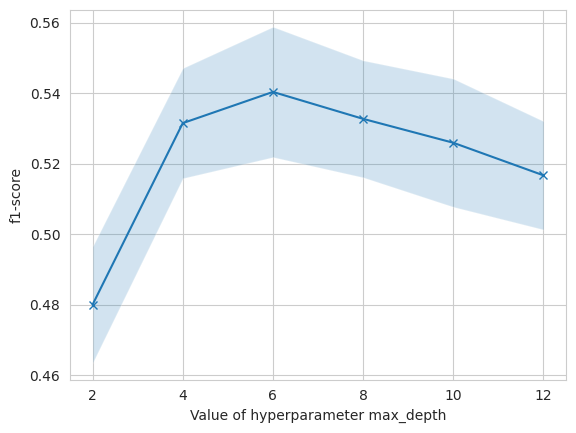

Optimal max_depth for Gradient Boosting = 6


In [308]:
scores = []
scores_std = []
list_max_depth = range(2, 13, 2)
for max_depth in (pbar:= tqdm(list_max_depth)):
    pbar.set_description(f"Running K-Fold with max_depth = {max_depth}")
    score, score_std = get_cross_validation_score(
        "f1", X_train, y_train, GradientBoostingClassifier, max_depth=max_depth
    )
    scores.append(score)
    scores_std.append(score_std)

plot_hyperparameters(list_max_depth, scores, scores_std, "max_depth")

optimal_max_depth_gb = list_max_depth[np.argmax(scores)]
print(f"Optimal max_depth for Gradient Boosting = {optimal_max_depth_gb}")

For performance reasons, I couldn't tune HPP for the Neural Network. A quick way to compensate for class imbalance in the NN would be to increase its loss function for false negatives. This would be doable by reimplementing a model in PyTorch, with a custom loss function.

# 4. Evaluation on test set
Now that we very superficially optimized the hyperparameters, let us train the models on the full training set according to these hyperparameters, then perform evaluation on the test set.

In [302]:
X_test = preprocess.transform(X_test_raw)[selected_features]

### Logistic Regression

In [303]:
logistic_regression = LogisticRegression(
    class_weight={0: 1, 1: optimal_positive_class_weight_lr}
)
logistic_regression.fit(X_train, y_train)

y_pred_lr = logistic_regression.predict(X_test)
print(f"F1 Score = {f1_score(y_test, y_pred_lr):.2f}")
print(f"Precision = {precision_score(y_test, y_pred_lr):.2f}")
print(f"Recall = {recall_score(y_test, y_pred_lr):.2f}")

F1 Score = 0.54
Precision = 0.49
Recall = 0.60


### Random Forest

In [304]:
rf_classifier = RandomForestClassifier(
    class_weight={0: 1, 1: optimal_positive_class_weight_lr}
)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)
print(f"F1 Score = {f1_score(y_test, y_pred_rf):.2f}")
print(f"Precision = {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall = {recall_score(y_test, y_pred_rf):.2f}")

F1 Score = 0.54
Precision = 0.51
Recall = 0.56


### Gradient Boosting

In [305]:
gb_classifier = GradientBoostingClassifier(n_estimators=200)
gb_classifier.fit(X_train, y_train)

y_pred_gb = gb_classifier.predict(X_test)
print(f"F1 Score = {f1_score(y_test, y_pred_gb):.2f}")
print(f"Precision = {precision_score(y_test, y_pred_gb):.2f}")
print(f"Recall = {recall_score(y_test, y_pred_gb):.2f}")

F1 Score = 0.52
Precision = 0.74
Recall = 0.40


### Simple NN
We didn't tune the NN parameters in the HPP tuning part, so we keep the vanilla parameters.

In [306]:
nn_classifier = MLPClassifier()
nn_classifier.fit(X_train, y_train)

y_pred_nn = nn_classifier.predict(X_test)
print(f"F1 Score = {f1_score(y_test, y_pred_nn):.2f}")
print(f"Precision = {precision_score(y_test, y_pred_nn):.2f}")
print(f"Recall = {recall_score(y_test, y_pred_nn):.2f}")

F1 Score = 0.50
Precision = 0.71
Recall = 0.38


The F1 scores are better for Random Forest and Logistic Regression, due to a higher recall. As the target seems to be the `Revenue >= 50k` and not the more frequent `Revenue < 50k`, Recall is the most limiting score for Gradient Boosting and NN, probably due to the fact that the dataset imbalance was not compensated for in their training.

# 5. Conclusion

In this notebook, we performed the following steps:
- Data cleaning
- Basic dataset exploration based on histograms
- Feature engineering:
    - Feature processing: One-hot encoding for categorical columns, Imputing and scaling for numerical columns
    - selection of the most 'impactful' features based on their correlation with the target
    - removal of inter-correlated features
- For several models:
    - Tuning of one hyperparameter via a 1-d search.
    - Evaluation on the test set.


For a real study with more time allotted, the elements I would focus more on to improve results are the following:
1. Dataset exploration to select better features (using e.g. Random Forest importance ranking)
2. Improve the tuning of hyperparameters, in particular on the NN where it was not done here for performance reasons. As mentioned, a quick way to compensate for class imbalance in the NN would be to increase its loss function for false negatives.
3. Try other models: XGBoost, SVC.

# End of notebook